In [ ]:
#important libraries
import pandas as pd
import numpy as np
import re
import itertools
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('all')
from nltk.stem.wordnet import WordNetLemmatizer 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize, pos_tag, pos_tag_sents
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from sklearn.preprocessing import OneHotEncoder
import gensim
from textblob.classifiers import NaiveBayesClassifier as NBC
from nltk.classify import NaiveBayesClassifier


**Data Acquisition**

In [ ]:
from google.colab import files
text = files.upload()

Saving train.txt to train.txt


In [ ]:
#data = pd.read_csv('train.txt', sep=',')
data = pd.read_csv('train.txt',sep=';',names=['Text','Emotion'])
data.head(2)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness


In [ ]:
uncleaned_train = data.copy()

In [ ]:
text = files.upload()

Saving test.txt to test.txt


In [ ]:
test=pd.read_csv('test.txt', sep=';',names=['Text','Emotion'])

In [ ]:
uncleaned_test = test.copy()

In [ ]:
text = files.upload()

Saving val.txt to val.txt


In [ ]:
val=pd.read_csv('val.txt', sep=';',names=['Text','Emotion'])

In [ ]:
uncleaned_val = val.copy()

In [ ]:
print(val.sample(2))
print(test.sample(2))
print(data.sample(2))

                                                  Text Emotion
550  im feeling kind of irritated that the school y...   anger
18   i also loved that you could really feel the de...    love
                                                   Text   Emotion
1721              i can t help feeling curious about it  surprise
1483  i feel like i am doomed to a life of sleep obs...   sadness
                                                    Text  Emotion
8966   i feel the presence of god something fearful h...     fear
15080  i haven t seen that side of him for a couple o...  sadness


**Exploratory Data Analysis (EDA)**

  Exploring the data information for all 3 dataframes, and do simple visualization that may help with useful insights.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

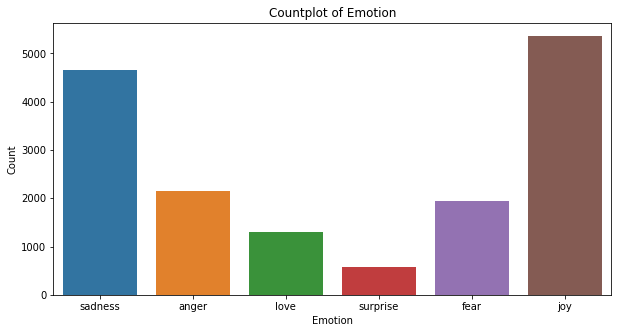

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data['Emotion'])
plt.title("Countplot of Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

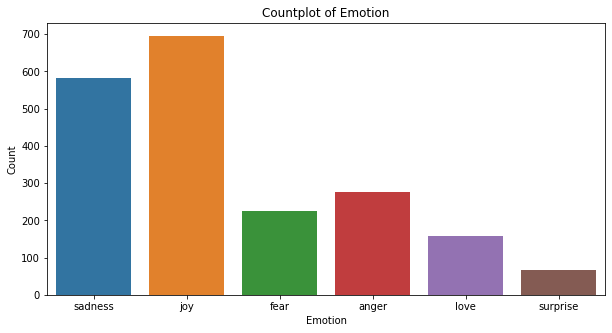

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(test['Emotion'])
plt.title("Countplot of Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

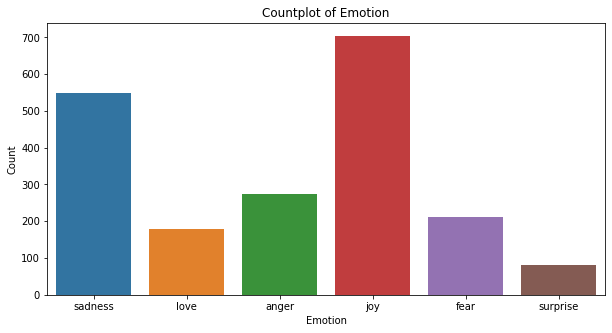

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(val['Emotion'])
plt.title("Countplot of Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")

From above plots within the three dataframes (test,train,val) we can conclude that Joy has the highest count overall emotions, and the lower is Surprise. This insight tells us that the model may perform better in Joy sentences than others.

In [ ]:
data['Emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

In [ ]:
test['Emotion'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64

In [ ]:
val['Emotion'].value_counts()

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64

In [ ]:
print(data.shape, test.shape, val.shape)

(16000, 2) (2000, 2) (2000, 2)


In [ ]:
data.isnull().sum()

Text       0
Emotion    0
dtype: int64

**Data Cleaning and Pre-processing**

  Make the text data clean, precise, and error-free.

In [ ]:
import string
def cleaning(text):
    text = text.lower()
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    clean = re.compile('<.*?>')
    text = re.sub(clean,'',text)
    text = pattern.sub('', text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"hes", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"shes", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"thats", "that is", text)         
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"whats", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"wheres", "where is", text)  
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"ive", "I have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"wasnt", "was not", text)
    text = re.sub(r"ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub('[^\w\s]','', text)
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [ ]:
data['Text'] = data['Text'].map(cleaning)
test['Text'] = test['Text'].map(cleaning)
val['Text'] = val['Text'].map(cleaning)

print("Cleaning is done")

Cleaning is done


In [ ]:
pip install preprocess

In [ ]:
from nltk.corpus import stopwords  
from gensim import parsing        # Help in preprocessing the data, very efficiently
import gensim
#import numpy as np

In [ ]:
def transformText(text):
  
    nltk.download('stopwords')
    stops = set(stopwords.words("english"))
    
    # Convert text to lower
    text = text.lower()
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Removing all the stopwords
    filtered_words = [word for word in text.split() if word not in stops]
    
    # Removing all the tokens with lesser than 3 characters
    filtered_words = gensim.corpora.textcorpus.remove_short(filtered_words, minsize=3)
    
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    
    # Strip all the numerics
    text = gensim.parsing.preprocessing.strip_numeric(text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Stemming
    return gensim.parsing.preprocessing.stem_text(text)

In [ ]:
data['Text'] = data['Text'].map(transformText)
test['Text'] = test['Text'].map(transformText)
val['Text'] = val['Text'].map(transformText)

Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-dat

In [ ]:
data.head()

,Text,Emotion
0,didnt feel humili,sadness
1,feel hopeless damn hope around someon care awak,sadness
2,grab minut post feel greedi wrong,anger
3,haver feel nostalg fireplac know still properti,love
4,feel grouchi,anger


In [ ]:
val.head()

,Text,Emotion
0,feel quit sad sorri ill snap soon,sadness
1,feel like still look blank canva blank piec paper,sadness
2,feel like faith servant,love
3,feel cranki blue,anger
4,treat feel festi,joy


In [ ]:
test.head()

,Text,Emotion
0,feel rather rotten haveri ambiti right,sadness
1,updat blog feel shitti,sadness
2,haver make separ haver want feel like asham,sadness
3,left bouquet red yellow tulip arm feel slightl...,joy
4,feel littl vain on,sadness


**Feature Engineering**

Extracting some features from the data that can be presented numerically to apply it to Machine learning models next step.

Extract Adjective Feature may help us in distinguishing the related emotion for given sentence/text.

In [ ]:
from textblob import TextBlob
def get_adjectives(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag == "JJ"]

data['adjectives'] = data['Text'].apply(get_adjectives)
val['adjectives'] = data['Text'].apply(get_adjectives)
test['adjectives'] = data['Text'].apply(get_adjectives)

Extract the Length of the sentence/text.

In [ ]:
data['Length'] = data.Text.apply(lambda x:len(x))
test['Length'] = test.Text.apply(lambda x:len(x))
val['Length'] = val.Text.apply(lambda x:len(x))

In [ ]:
data.head()

,Text,Emotion,adjectives,Length
0,didnt feel humili,sadness,[],17
1,feel hopeless damn hope around someon care awak,sadness,[hopeless],47
2,grab minut post feel greedi wrong,anger,[wrong],33
3,haver feel nostalg fireplac know still properti,love,[nostalg],47
4,feel grouchi,anger,[],12


 Using Tokenizer Class to convert the sentences into word vectors.

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_train_test = pd.concat([data['Text'], test.Text], axis = 0)
tokenizer.fit_on_texts(df_train_test)

In [ ]:
uniques= len(tokenizer.word_index) # this is whole unique words in our corpus
print('No. of unique tokens in the dataset:', uniques)
# but we are taking only 10000 words in our model

No. of unique tokens in the dataset: 10795


**Padding:** each input has the same length.

We should define maximum number of words for our corpus and the input size to our model need to be fixed.

For cleaned data

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train=tokenizer.texts_to_sequences(data['Text'])
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post')
X_test = tokenizer.texts_to_sequences(test.Text)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')
X_val = tokenizer.texts_to_sequences(val.Text)
X_val_pad = pad_sequences(X_val, maxlen = 300, padding = 'post')

Categorizing the labels.

In [ ]:
from keras.utils import to_categorical

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
     'love':4 , 'surprise':5
}

y_train = [encoding[x] for x in data.Emotion]
y_test = [encoding[x] for x in test.Emotion]
y_val = [encoding[x] for x in val.Emotion]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
print(X_train_pad.shape, X_val_pad.shape)

(16000, 300) (2000, 300)


For uncleaned data

In [ ]:
df_train_test_u = pd.concat([uncleaned_train['Text'], uncleaned_test.Text], axis = 0)
tokenizer.fit_on_texts(df_train_test_u)

In [ ]:

X_train_u=tokenizer.texts_to_sequences(uncleaned_train['Text'])
X_train_pad_u=pad_sequences(X_train_u,maxlen=300,padding='post')
X_test_u = tokenizer.texts_to_sequences(uncleaned_test.Text)
X_test_pad_u = pad_sequences(X_test_u, maxlen = 300, padding = 'post')
X_val_u = tokenizer.texts_to_sequences(uncleaned_val.Text)
X_val_pad_u = pad_sequences(X_val, maxlen = 300, padding = 'post')

In [ ]:
y_train_u = [encoding[x] for x in uncleaned_train.Emotion]
y_test_u = [encoding[x] for x in uncleaned_test.Emotion]
y_val_u = [encoding[x] for x in uncleaned_val.Emotion]

y_train_u = to_categorical(y_train_u)
y_test_u = to_categorical(y_test_u)
y_val_u = to_categorical(y_val_u)

**Word2Vec:** 
create weighted matrix using gensim word2vec.

In [ ]:
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors
glove_gensim  = api.load('glove-wiki-gigaword-100')#,return_path=True) #100 dimension
#print(glove_gensim)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
w2vec_model = KeyedVectors.load_word2vec_format('/root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz', binary=True,encoding= 'unicode_escape' )#word2vec model
#w2vec_model = KeyedVectors.load_word2vec_format('/Users/dollyrawat/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz', binary=True, encoding= 'unicode_escape' )#word2vec model

In [ ]:
word_vectors = glove_gensim.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
glove_gensim.similarity('straightforward', 'easy')

0.691149

In [ ]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape 

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in word_vectors.vocab:
            gensim_weight_matrix[index] = word_vectors[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [ ]:
gensim_weight_matrix.shape

(10000, 100)

**TF-IDF**

In [ ]:
my_tags = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

#Preparing the pipeline for Naive bayes classifier
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [ ]:
from sklearn.linear_model import SGDClassifier

#Preparing the pipeline for SVM.
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

**Modeling and Evaluating.**
  
  In this step we are doing the models and evaluate each one of them.

**LSTM** model with GPU support.

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
# tf.compat.v1.keras.layers.CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

In [ ]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

for uncleaned data

In [ ]:

model_u = Sequential()
model_u.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad_u.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_u.add(Dropout(0.2))
model_u.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model_u.add(Dropout(0.2))
model_u.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model_u.add(Dropout(0.2))
model_u.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model_u.add(Dense(6, activation = 'softmax'))
model_u.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint


#es = EarlyStopping(monitor = 'val_accuracy', mode = 'min', verbose = 1, patience = 5)
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history_embedding = model.fit(X_train_pad,y_train, validation_split=0.33, epochs=25, batch_size=120, validation_data=(X_val_pad, y_val),verbose = 1, callbacks= callbacks_list)
#model.evaluate(train.batch(batch_size), steps=None, verbose=1)

Epoch 1/25
90/90 [==============================] - 90s 629ms/step - loss: 1.5648 - accuracy: 0.3693 - val_loss: 1.4128 - val_accuracy: 0.4505

Epoch 00001: val_accuracy improved from inf to 0.45048, saving model to weights-improvement-01-0.45.hdf5
Epoch 2/25
90/90 [==============================] - 55s 612ms/step - loss: 1.4001 - accuracy: 0.4552 - val_loss: 1.3212 - val_accuracy: 0.4884

Epoch 00002: val_accuracy did not improve from 0.45048
Epoch 3/25
90/90 [==============================] - 55s 613ms/step - loss: 1.3059 - accuracy: 0.5010 - val_loss: 1.2301 - val_accuracy: 0.5421

Epoch 00003: val_accuracy did not improve from 0.45048
Epoch 4/25
90/90 [==============================] - 55s 611ms/step - loss: 1.2017 - accuracy: 0.5511 - val_loss: 1.1992 - val_accuracy: 0.5344

Epoch 00004: val_accuracy did not improve from 0.45048
Epoch 5/25
90/90 [==============================] - 55s 609ms/step - loss: 1.1292 - accuracy: 0.5779 - val_loss: 1.1270 - val_accuracy: 0.5717

Epoch 0000

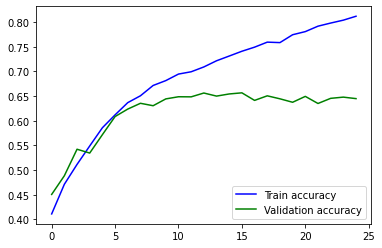

In [ ]:
#Accuracy plot

plt.plot(history_embedding.history['accuracy'],c='b',label='Train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='g',label='Validation accuracy')
plt.legend(loc='lower right')
plt.show()

From above plot we can summarize that the model could have stopped at epoch of 6 and attain a train accuracy of 0.65 and validation accuracy of 0.60, But as shown the model we have is over-fitting our train dataset.

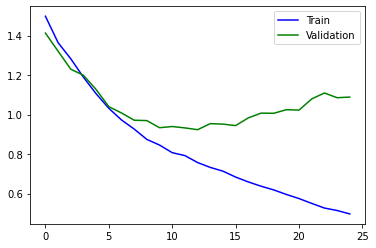

In [ ]:
#Loss plot
plt.plot(history_embedding.history['loss'],c='blue',label='Train')
plt.plot(history_embedding.history['val_loss'],c='g',label='Validation')
plt.legend(loc='upper right')
plt.show()

Loss is a summation of the errors made for each example in training or validation sets, so the lower the loss the better the model. But as we are noticing from above plot, the loss does not turning to the lowest so fast. From above Loss plot we can insure our pre-analysis of the accuracy plot, Which is that our model is truly over-fitting the train dataset.

For uncleaned data

In [ ]:
history_embedding_u = model.fit(X_train_pad_u,y_train_u, validation_split=0.33, epochs=25, batch_size=120, validation_data=(X_val_pad_u, y_val_u),verbose = 1, callbacks= callbacks_list)


Epoch 1/25
90/90 [==============================] - 55s 608ms/step - loss: 1.6406 - accuracy: 0.3318 - val_loss: 1.5708 - val_accuracy: 0.3416

Epoch 00001: val_accuracy improved from 0.45048 to 0.34160, saving model to weights-improvement-01-0.34.hdf5
Epoch 2/25
90/90 [==============================] - 55s 610ms/step - loss: 1.5669 - accuracy: 0.3524 - val_loss: 1.5623 - val_accuracy: 0.3427

Epoch 00002: val_accuracy did not improve from 0.34160
Epoch 3/25
90/90 [==============================] - 55s 608ms/step - loss: 1.5525 - accuracy: 0.3666 - val_loss: 1.5454 - val_accuracy: 0.3579

Epoch 00003: val_accuracy did not improve from 0.34160
Epoch 4/25
90/90 [==============================] - 54s 606ms/step - loss: 1.5271 - accuracy: 0.3826 - val_loss: 1.5197 - val_accuracy: 0.3736

Epoch 00004: val_accuracy did not improve from 0.34160
Epoch 5/25
90/90 [==============================] - 55s 609ms/step - loss: 1.4856 - accuracy: 0.4021 - val_loss: 1.4805 - val_accuracy: 0.4113

Epoch 

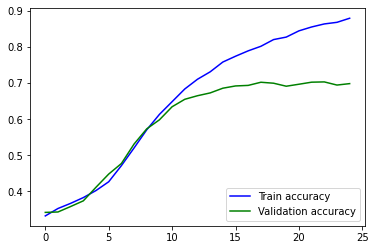

In [ ]:

plt.plot(history_embedding_u.history['accuracy'],c='b',label='Train accuracy')
plt.plot(history_embedding_u.history['val_accuracy'],c='g',label='Validation accuracy')
plt.legend(loc='lower right')
plt.show()

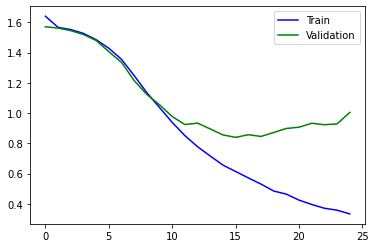

In [ ]:
plt.plot(history_embedding_u.history['loss'],c='blue',label='Train')
plt.plot(history_embedding_u.history['val_loss'],c='g',label='Validation')
plt.legend(loc='upper right')
plt.show()

Evaluation:

In [ ]:
model.evaluate(X_test_pad, y_test) 

63/63 [==============================] - 10s 155ms/step - loss: 2.7791 - accuracy: 0.3215


[2.779060125350952, 0.3215000033378601]

In [ ]:
y_true = np.argmax(y_test, axis = 1)
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)

from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.42      0.37      0.40       788
           1       0.14      0.20      0.16       158
           2       0.16      0.21      0.18       214
           3       0.45      0.37      0.41       705
           4       0.07      0.15      0.09        73
           5       0.03      0.03      0.03        62

    accuracy                           0.32      2000
   macro avg       0.21      0.22      0.21      2000
weighted avg       0.36      0.32      0.34      2000



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

Confusion Matrix for LSTM 



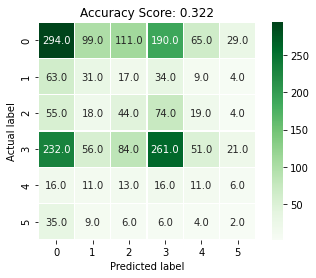

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("Confusion Matrix for LSTM","\n")
score = round(accuracy_score(y_pred, y_true),3) 
cm1 = confusion_matrix(y_pred, y_true)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

In [ ]:
#user testing
def get_key(value):
     dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
     for key,val in dictionary.items():
           if (val==value):
             return key

def predict(text):
    text_lst=[]
    text_lst.append(text)
    text_seq=tokenizer.texts_to_sequences(text_lst)
    text_padded=pad_sequences(text_seq,maxlen=300,padding='post')
    ans=get_key(model.predict_classes(text_padded))
    print("Your Emotion is: ",ans)

In [ ]:
#user testing cont.
predict(str(input('Enter a sentence: ')))

Enter a sentence: i feel bad
Your Emotion is:  sadness


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Evaluation for uncleaned data

In [ ]:
model_u.evaluate(X_test_pad_u, y_test_u) 

63/63 [==============================] - 12s 187ms/step - loss: 1.7841 - accuracy: 0.1810


[1.7840979099273682, 0.1809999942779541]

In [ ]:
y_true_u = np.argmax(y_test_u, axis = 1)
y_pred_u =   np.argmax(model_u.predict(X_test_pad_u), axis  =  1)


print(metrics.classification_report(y_pred_u, y_true_u))

              precision    recall  f1-score   support

           0       0.22      0.37      0.28       419
           1       0.08      0.14      0.10       138
           2       0.56      0.13      0.21      1184
           3       0.04      0.34      0.08        74
           4       0.06      0.05      0.06       185
           5       0.00      0.00      0.00         0

    accuracy                           0.18      2000
   macro avg       0.16      0.17      0.12      2000
weighted avg       0.39      0.18      0.20      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_u(text):
    text_lst=[]
    text_lst.append(text)
    text_seq=tokenizer.texts_to_sequences(text_lst)
    text_padded=pad_sequences(text_seq,maxlen=300,padding='post')
    ans_u=get_key(model_u.predict_classes(text_padded))
    print("Your Emotion is: ",ans_u)

In [ ]:
predict_u(str(input('Enter a sentence: ')))

Enter a sentence: i feel bad
Your Emotion is:  love


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**Naive Bayes with tf-idf**

In [ ]:
train1 = data.copy()
test1 = test.copy()
val1 = val.copy()

In [ ]:
train2 = uncleaned_train.copy()
test2 = uncleaned_test.copy()
val2 = uncleaned_val.copy()

In [ ]:
#Dividing the data into x and y
xtrain , xtest , xval = train1['Text'].values , test1['Text'].values , val1['Text'].values

ytrain, ytest, yval = train1['Emotion'].values, test1['Emotion'].values, val1['Emotion'].values

In [ ]:
nb.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:

xtrain2 , xtest2 , xval2 = train2['Text'].values , test2['Text'].values , val2['Text'].values

ytrain2, ytest2, yval2 = train2['Emotion'].values, test2['Emotion'].values, val2['Emotion'].values

Evaluation:

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score

y_pred = nb.predict(xtest)
#y_true = np.argmax(ytest, axis = 1)

print('accuracy %s' % accuracy_score(y_pred, ytest))
print(classification_report(ytest, y_pred,target_names=my_tags))

accuracy 0.6905
              precision    recall  f1-score   support

         joy       0.92      0.35      0.51       275
     sadness       0.91      0.34      0.50       224
       anger       0.65      0.97      0.78       695
        fear       1.00      0.09      0.16       159
        love       0.68      0.89      0.77       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.69      2000
   macro avg       0.69      0.44      0.45      2000
weighted avg       0.73      0.69      0.63      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for Naive Bayes 



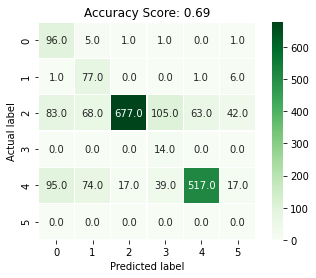

In [ ]:
print("Confusion Matrix for Naive Bayes","\n")
score = round(accuracy_score(y_pred, ytest),3) 
cm1 = confusion_matrix(y_pred, ytest)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

For uncleaned data

In [ ]:


y_pred2 = nb.predict(xtest2)
#y_true = np.argmax(ytest, axis = 1)

print('accuracy %s' % accuracy_score(y_pred2, ytest2))
print(classification_report(ytest2, y_pred2,target_names=my_tags))

accuracy 0.4625
              precision    recall  f1-score   support

         joy       0.73      0.07      0.13       275
     sadness       0.82      0.10      0.18       224
       anger       0.47      0.75      0.58       695
        fear       0.57      0.05      0.09       159
        love       0.43      0.61      0.51       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.46      2000
   macro avg       0.50      0.26      0.25      2000
weighted avg       0.53      0.46      0.39      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Naive Bayes with Word2Vec**

In [ ]:
#word2vec embedding function

def word2vec_embedding(tokens):
  length_tokenz=len(tokens)

  W2vectors=[]

# adding the word2vec average

  for word in tokens:
      if word not in word_vectors.vocab:
            W2vectors.append([0]*100) 
      else:
            #W2vectors.append(w2vec_model[word])
            W2vectors.append(glove_gensim[word])
      
      length_vect = len(W2vectors[0])

      result=[0] * length_vect 
      x=0
  
      for i in range(length_vect): 
         for vector in W2vectors:
                x+=vector[i]
         result[i]=(x/length_tokenz) 
         x=0
         
  return result

In [ ]:
w2v_xtrain = [word2vec_embedding(i) for i in xtrain]

In [ ]:
w2v_xtest = [word2vec_embedding(i) for i in xtest]

In [ ]:
w2v_xtrain2 = [word2vec_embedding(i) for i in xtrain2]
w2v_xtest2 = [word2vec_embedding(i) for i in xtest2]

In [ ]:
#nb_w2v = MultinomialNB()
#nb_w2v.fit(w2v_xtrain,ytrain)

Evaluation

**SVM with tf-idf**

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd.fit(xtrain, ytrain)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [ ]:
sgd.fit(xtrain2, ytrain2)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

Evaluation



In [ ]:
from sklearn.metrics import classification_report
y_pred = sgd.predict(xtest)

print('accuracy %s' % accuracy_score(y_pred, ytest))
print(classification_report(ytest, y_pred,target_names=my_tags))

accuracy 0.514
              precision    recall  f1-score   support

         joy       0.89      0.17      0.29       275
     sadness       0.90      0.25      0.39       224
       anger       0.48      0.84      0.61       695
        fear       0.91      0.13      0.22       159
        love       0.51      0.55      0.53       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.51      2000
   macro avg       0.61      0.32      0.34      2000
weighted avg       0.61      0.51      0.47      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for SVM 



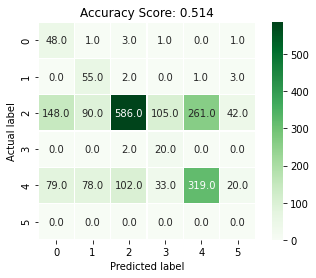

In [ ]:
print("Confusion Matrix for SVM","\n")
score = round(accuracy_score(y_pred, ytest),3) 
cm1 = confusion_matrix(y_pred, ytest)
sns.heatmap(cm1, annot=True, fmt=".1f", linewidths=.3, 
        square = True, cmap = 'Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0}'.format(score), size = 12)
plt.show()
print("\n")

In [ ]:
y_pred2 = sgd.predict(xtest2)

print('accuracy %s' % accuracy_score(y_pred2, ytest2))
print(classification_report(ytest2, y_pred2,target_names=my_tags))

accuracy 0.8755
              precision    recall  f1-score   support

         joy       0.91      0.83      0.87       275
     sadness       0.88      0.80      0.84       224
       anger       0.84      0.97      0.90       695
        fear       0.91      0.59      0.72       159
        love       0.90      0.93      0.91       581
    surprise       0.91      0.48      0.63        66

    accuracy                           0.88      2000
   macro avg       0.89      0.77      0.81      2000
weighted avg       0.88      0.88      0.87      2000



**SVM with Word2Vec**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

In [ ]:
svc_w2v = LinearSVC()
svc_w2v.fit(w2v_xtrain,ytrain)
# svc_w2v = GridSearchCV(LinearSVC(max_iter = 50000), param_grid, refit = True, verbose = 3) 
# svc_w2v.fit(x_train,y_train)

NameError: ignored

In [ ]:
svc_w2v2 = LinearSVC()
svc_w2v2.fit(w2v_xtrain2,ytrain2)

Evaluation

In [ ]:
y_pred = svc_w2v.predict(w2v_xtest)

print('accuracy %s' % accuracy_score(y_pred, ytest))
print(classification_report(ytest, y_pred,target_names=my_tags))

accuracy 0.3975
              precision    recall  f1-score   support

         joy       0.00      0.00      0.00       275
     sadness       0.33      0.00      0.01       224
       anger       0.41      0.72      0.52       695
        fear       0.00      0.00      0.00       159
        love       0.38      0.50      0.43       581
    surprise       0.56      0.08      0.13        66

    accuracy                           0.40      2000
   macro avg       0.28      0.22      0.18      2000
weighted avg       0.31      0.40      0.31      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred2 = svc_w2v2.predict(w2v_xtest2)

print('accuracy %s' % accuracy_score(y_pred2, ytest2))
print(classification_report(ytest2, y_pred2,target_names=my_tags))

##**Thank you!**